# Convolutional Neural Networks for Image Recognition
## Advanced Machine Learning

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import fnmatch
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.layers import Convolution2D, Dense, MaxPooling2D, Flatten, BatchNormalization, Dropout
from tensorflow.keras import Sequential
import random
import re

# pip install pypng
import png
import sklearn.metrics

# Provided 
from core50 import *

##################
# Configure figure parameters

FONTSIZE = 18
FIGURE_SIZE = (10,4)
FIGURE_SIZE2 = (10,10)

plt.rcParams.update({'font.size': FONTSIZE})
plt.rcParams['figure.figsize'] = FIGURE_SIZE
# Default tick label size
plt.rcParams['xtick.labelsize'] = FONTSIZE
plt.rcParams['ytick.labelsize'] = FONTSIZE

## TURN OFF GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

/tmp/ipykernel_1150044/3985610497.py:7: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  image_2d = np.vstack(map(np.uint8, it[2]))


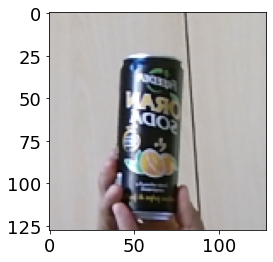

In [2]:
# Load up a single image & view it
directory = '/home/fagg/datasets/core50/core50_128x128/s1/o21'
files = os.listdir(directory)

r = png.Reader(directory + "/" + files[0])
it = r.read()
image_2d = np.vstack(map(np.uint8, it[2]))
image_3d = np.reshape(image_2d,
                         (128,128,3))

plt.imshow(image_3d)

## Load Data Sets

In [3]:
## File location
directory_base = '/home/fagg/datasets/core50/core50_128x128'

# Training set: define which files to load for each object
#val = '.*[05].png'
val_files = '.*[0].png'

### Positive cases
# Define which objects to load
#object_list = ['o25', 'o22', 'o23', 'o24']
object_list = ['o21']

# Define which conditions to load
#condition_list = ['s1', 's2', 's3', 's4', 's5', 's7', 's8', 's9', 's10', 's11']
#condition_list = ['s1', 's2', 's3', 's4']
condition_list = ['s1']

# Load all of the objects/condition
ins_pos = load_multiple_image_sets_from_directories(directory_base, condition_list, object_list, val_files)

### Negative cases
# Define which objects to load
#object_list2 = ['o45', 'o42', 'o43', 'o44']
object_list2 = ['o41']
ins_neg = load_multiple_image_sets_from_directories(directory_base, condition_list, object_list2, val_files)

### Combine positives and negatives into a common data set
outs_pos = np.append(np.ones((ins_pos.shape[0],1)), np.zeros((ins_pos.shape[0],1)), axis=1)
outs_neg = np.append(np.zeros((ins_pos.shape[0],1)), np.ones((ins_pos.shape[0],1)), axis=1)

ins = np.append(ins_pos, ins_neg, axis=0)
outs = np.append(outs_pos, outs_neg, axis=0)

########################################################################
# Validation set
# Define which files to load for each object
val_files = '.*[5].png'

### Positives
# Define which objects to load
object_list = ['o21']
#object_list = ['o21']

# Load the positives
ins_pos_validation = load_multiple_image_sets_from_directories(directory_base, condition_list, object_list, val_files)

### Negatives
# Define objects
object_list2 = ['o41']
#object_list2 = ['o41']

# Load the negative cases
ins_neg_validation = load_multiple_image_sets_from_directories(directory_base, condition_list, object_list2, val_files)

### Combine positives and negatives
outs_pos_validation = np.append(np.ones((ins_pos_validation.shape[0], 1)), np.zeros((ins_pos_validation.shape[0], 1)), axis=1)
outs_neg_validation = np.append(np.zeros((ins_pos_validation.shape[0], 1)), np.ones((ins_pos_validation.shape[0], 1)), axis=1)

ins_validation = np.append(ins_pos_validation, ins_neg_validation, axis=0)
outs_validation = np.append(outs_pos_validation, outs_neg_validation, axis=0)

##################
/home/fagg/datasets/core50/core50_128x128/s1/o21 .*[0].png
##################
/home/fagg/datasets/core50/core50_128x128/s1/o41 .*[0].png
##################
/home/fagg/datasets/core50/core50_128x128/s1/o21 .*[5].png
##################
/home/fagg/datasets/core50/core50_128x128/s1/o41 .*[5].png


In [4]:
ins.shape

(60, 128, 128, 3)

In [6]:
outs.shape

(60, 2)

In [9]:
outs[50,:]

array([0., 1.])

In [10]:
ins_validation.shape

(60, 128, 128, 3)

In [11]:
outs_validation.shape

(60, 2)

## Create Network

In [16]:
def create_classifier_network(image_size, nchannels, n_classes, lambda_l2=None, p_dropout=0.5):
    if lambda_l2 is not None:
        lambda_l2 = tf.keras.regularizers.l2(lambda_l2)
        
    model = Sequential()
    model.add(InputLayer(input_shape=(image_size[0], image_size[1], nchannels)))
    
    model.add(Convolution2D(filters = 10,
                            kernel_size = (5,5),
                            strides = 1,
                            padding = 'valid',
                            use_bias = True,
                            kernel_initializer='random_uniform',
                            bias_initializer='zeros',
                            name = 'C1',
                            activation = 'elu',
                            kernel_regularizer = lambda_l2))
    
    model.add(MaxPooling2D(pool_size=(2,2), 
                           strides = (2,2)))
    
    model.add(Flatten())
    
    model.add(Dense(units=100,
                    activation='elu',
                    use_bias = True,
                    kernel_initializer='random_uniform',
                    bias_initializer='zeros',
                    name = 'D1',
                    kernel_regularizer = lambda_l2))
    
    model.add(Dropout(p_dropout))
    
    # Output layer
    model.add(Dense(units=n_classes,
                    activation='softmax',
                    use_bias = True,
                    kernel_initializer='truncated_normal',
                    bias_initializer='zeros',
                    name = 'output',
                    kernel_regularizer = lambda_l2))
    
    opt = tf.keras.optimizers.Adam(lr=.0001, beta_1=0.9, beta_2=0.999,
                                   epsilon=None, decay=0.0, amsgrad=False)
    
    model.compile(loss='categorical_crossentropy', optimizer=opt,
                  metrics=['categorical_accuracy'])
    
    
    print(model.summary())
    
    return model


In [20]:
model = create_classifier_network((ins.shape[1], ins.shape[2]), ins.shape[3], 2)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
C1 (Conv2D)                  (None, 124, 124, 10)      760       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 62, 62, 10)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 38440)             0         
_________________________________________________________________
D1 (Dense)                   (None, 100)               3844100   
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
output (Dense)               (None, 2)                 202       
Total params: 3,845,062
Trainable params: 3,845,062
Non-trainable params: 0
____________________________________________

In [21]:
# Callbacks
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,
                                                  restore_best_weights=True,
                                                      min_delta=0.01)

In [22]:
history = model.fit(x=ins, y=outs, epochs=30, verbose=1,
                        validation_data=(ins_validation, outs_validation), 
                        callbacks=[early_stopping_cb])

Epoch 1/30
2/2 [==============================] - 1s 212ms/step - loss: 0.9206 - categorical_accuracy: 0.4333 - val_loss: 0.7073 - val_categorical_accuracy: 0.5000
Epoch 2/30
2/2 [==============================] - 0s 147ms/step - loss: 0.7458 - categorical_accuracy: 0.4667 - val_loss: 0.7404 - val_categorical_accuracy: 0.5000
Epoch 3/30
2/2 [==============================] - 0s 141ms/step - loss: 0.7425 - categorical_accuracy: 0.5000 - val_loss: 0.6651 - val_categorical_accuracy: 0.5000
Epoch 4/30
2/2 [==============================] - 0s 121ms/step - loss: 0.6664 - categorical_accuracy: 0.5667 - val_loss: 0.6243 - val_categorical_accuracy: 0.6167
Epoch 5/30
2/2 [==============================] - 0s 124ms/step - loss: 0.6485 - categorical_accuracy: 0.6167 - val_loss: 0.6244 - val_categorical_accuracy: 0.5000
Epoch 6/30
2/2 [==============================] - 0s 130ms/step - loss: 0.5866 - categorical_accuracy: 0.6833 - val_loss: 0.5936 - val_categorical_accuracy: 0.6500
Epoch 7/30
2/2 [

## Evaluation

In [23]:
def generate_roc(model, ins, outs, ins_validation, outs_validation):
    '''
    Produce a ROC plot given a model, a set of inputs and the true outputs
    
    Assume that model produces N-class output; we will only look at the class 0 scores
    '''
    # Compute probabilistic predictions given images
    pred = model.predict(ins)
    # Compute false positive rate & true positive rate + AUC
    fpr, tpr, thresholds = sklearn.metrics.roc_curve(outs[:,0], pred[:,0])
    auc = sklearn.metrics.auc(fpr, tpr)
    
    # Compute probabilistic predictions given images
    pred_val = model.predict(ins_validation)
    # Compute false positive rate & true positive rate + AUC
    fpr_val, tpr_val, thresholds_val = sklearn.metrics.roc_curve(outs_validation[:,0], pred_val[:,0])
    auc_val = sklearn.metrics.auc(fpr_val, tpr_val)
    
    
    # Generate the plot
    plt.figure(1)
    plt.axis('equal')
    plt.plot([0,1], [0,1], 'k--')
    plt.plot(fpr, tpr, 'b', label='Train AUC = {:.3f}'.format(auc))
    plt.plot(fpr_val, tpr_val, 'r', label='Validation AUC = {:.3f}'.format(auc_val))
    plt.legend(loc='best')
    plt.xlabel('FPR', fontsize=FONTSIZE)
    plt.ylabel('TPR', fontsize=FONTSIZE)
    

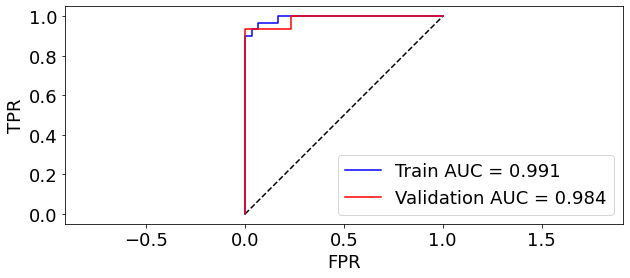

In [25]:
generate_roc(model, ins, outs, ins_validation, outs_validation)

In [24]:
model.predict(ins_validation)

array([[0.9625128 , 0.03748715],
       [0.9619298 , 0.03807016],
       [0.95831865, 0.04168132],
       [0.93531996, 0.06468005],
       [0.9046577 , 0.09534226],
       [0.9542011 , 0.0457989 ],
       [0.8812342 , 0.11876571],
       [0.91179776, 0.0882022 ],
       [0.72571117, 0.2742888 ],
       [0.9149858 , 0.08501421],
       [0.9326042 , 0.06739575],
       [0.8783739 , 0.12162609],
       [0.82304263, 0.17695737],
       [0.9274055 , 0.07259446],
       [0.8577855 , 0.14221452],
       [0.9721433 , 0.02785667],
       [0.7989463 , 0.20105365],
       [0.8000088 , 0.19999126],
       [0.9640547 , 0.03594538],
       [0.9880541 , 0.01194588],
       [0.95240134, 0.04759867],
       [0.8943746 , 0.10562541],
       [0.92456543, 0.07543457],
       [0.9418243 , 0.05817571],
       [0.7456825 , 0.25431755],
       [0.96272844, 0.03727162],
       [0.9465116 , 0.05348834],
       [0.8191162 , 0.1808838 ],
       [0.29551035, 0.7044897 ],
       [0.30473936, 0.69526064],
       [0.

## Visualize Model Internals

In [26]:
def intermediate_model_state(model, ins, layer_list):
    '''
    Return layer activations for intermediate layers in a model for a set of examples
    
    :param model: Model in question
    :param ins: Input tensor (examples, rows, cols, channels)
    :param layer_list: List of layer names to produce activations for
    :returns: a list of numpy arrays
    '''
    # Translate layer names into corresponding output tensors
    layer_outputs = [l.output for l in model.layers if l.name in layer_list]
    
    # Construct a new Keras model that outputs these tensors
    # The internal structure of the model itself is referenced through the input and output tensor lists
    new_model = keras.models.Model(inputs=model.input, outputs=layer_outputs)
    
    # Evaluate the new model
    activations = new_model.predict(ins_validation)
    
    # Return a list of activation numpy arrays
    return activations

def visualize_state(activations, width=1, example=0, cmap='plasma'):
    '''
    Produce graphical representation of a set of image channels
    
    :param activations: numpy array (example, rows, cols, channels)
    :param width: Number of images displayed horizontally
    :param example: Index of example to display
    :param cmap: Color map to use for plotting
    '''
    # Size of the individual images
    nrows = activations.shape[1]
    ncols = activations.shape[2]
    # Number of channels
    nfilters = activations.shape[3]
    
    # Tile all of the sub-images 
    grid = np.zeros((int((nfilters-1)/width + 1) * nrows, ncols * width))
    
    # Loop over image
    for i in range(nfilters):
        # Compute r,c of tile to place the ith image into
        r = int(i / width)
        c = i % width
        grid[nrows*r: nrows*(r+1), ncols*c:ncols*(c+1)] = activations[example,:,:,i]
        
    # Plot
    plt.matshow(grid, cmap=cmap) 

In [27]:
# Compute activations for 2 layers over a set of examples
layer_list=['C1']
activations = intermediate_model_state(model, ins_validation, layer_list)

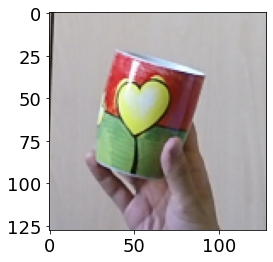

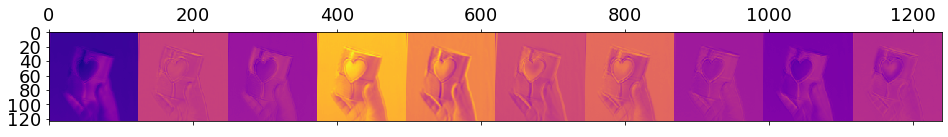

In [28]:
# Plot convolutional layers 1 and 2
example=40
plt.imshow(ins_validation[example,:,:,:])
visualize_state(activations, width=10, example=example)
#visualize_state(activations[0], width=10, example=example)
#visualize_state(activations[1], width=20, example=example)
#visualize_state(activations[2], width=20, example=example)
#visualize_state(activations[3], width=30, example=example)